In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset



In [7]:
import sys
import time
import warnings
warnings.filterwarnings("ignore")

In [9]:
## read data
train=pd.read_csv('training_data.csv')
test=pd.read_csv('test_data.csv')

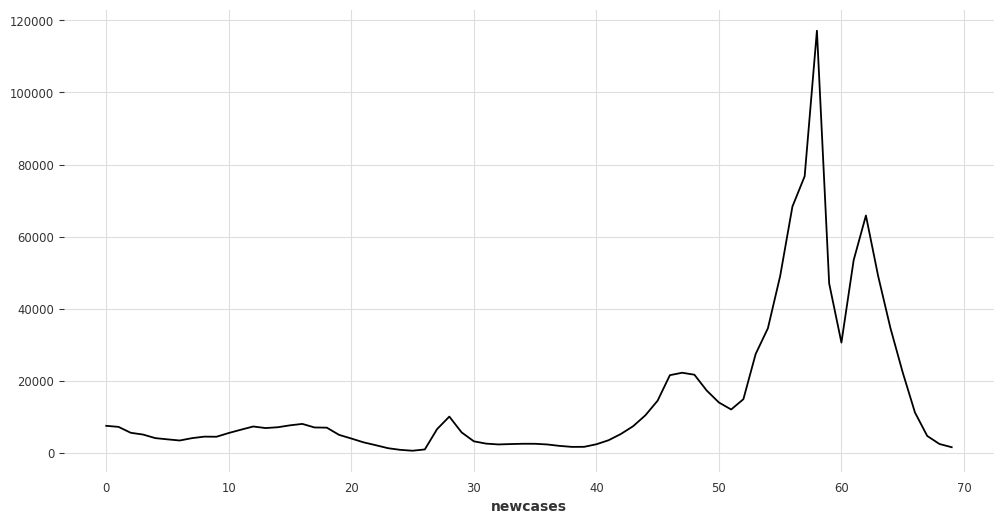

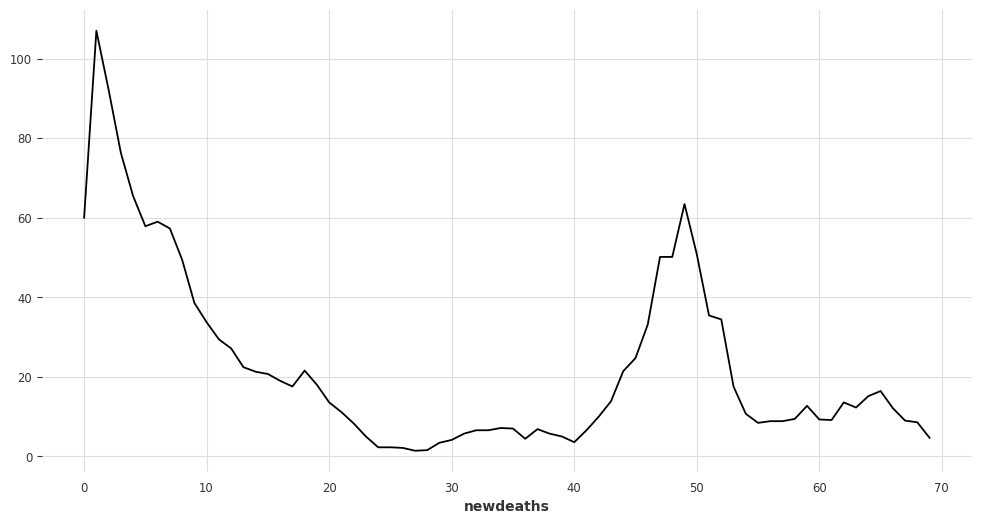

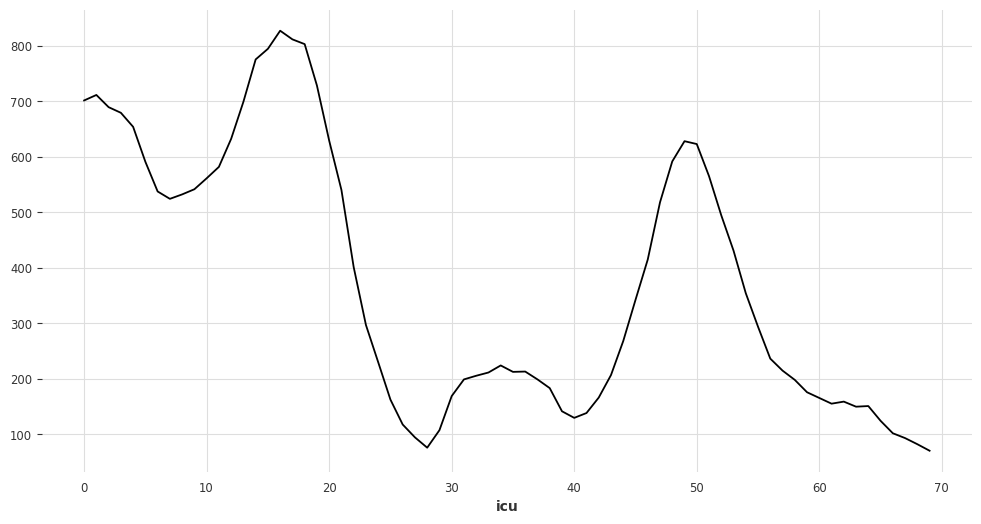

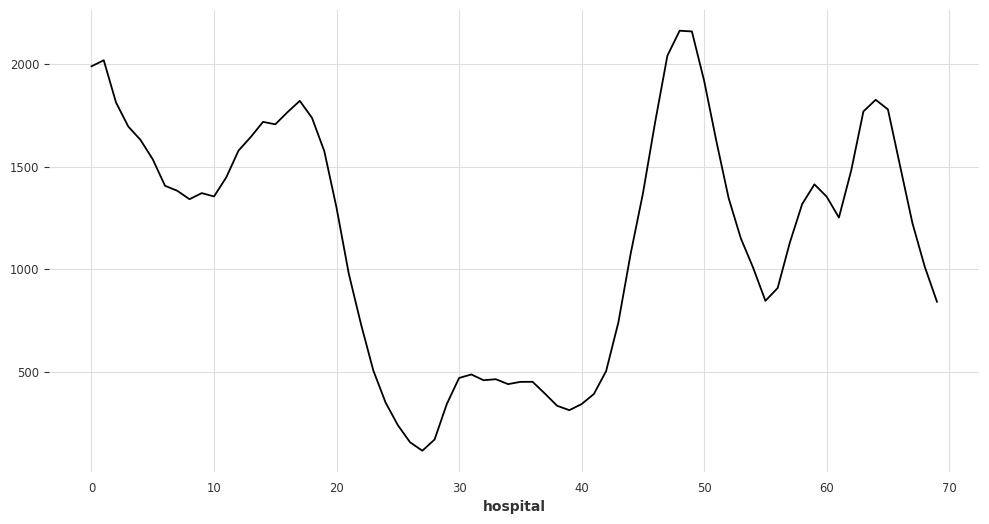

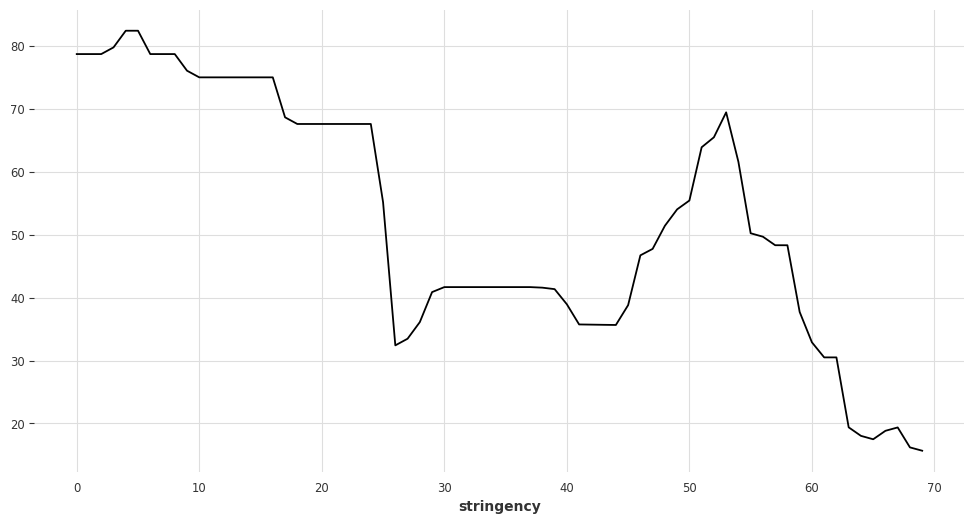

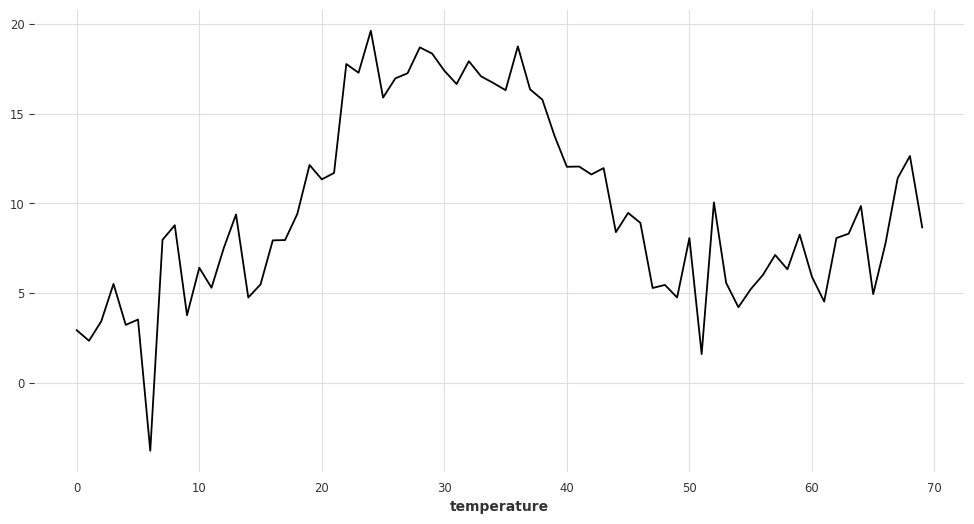

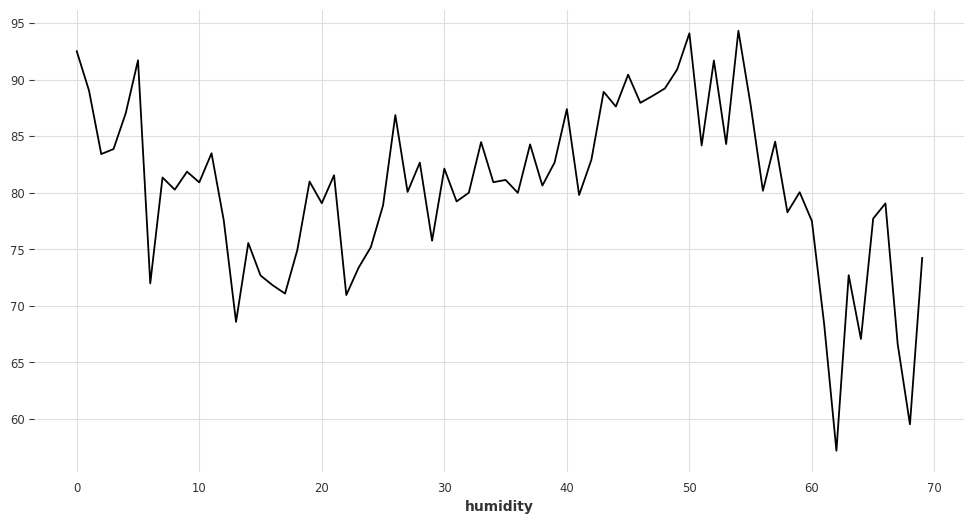

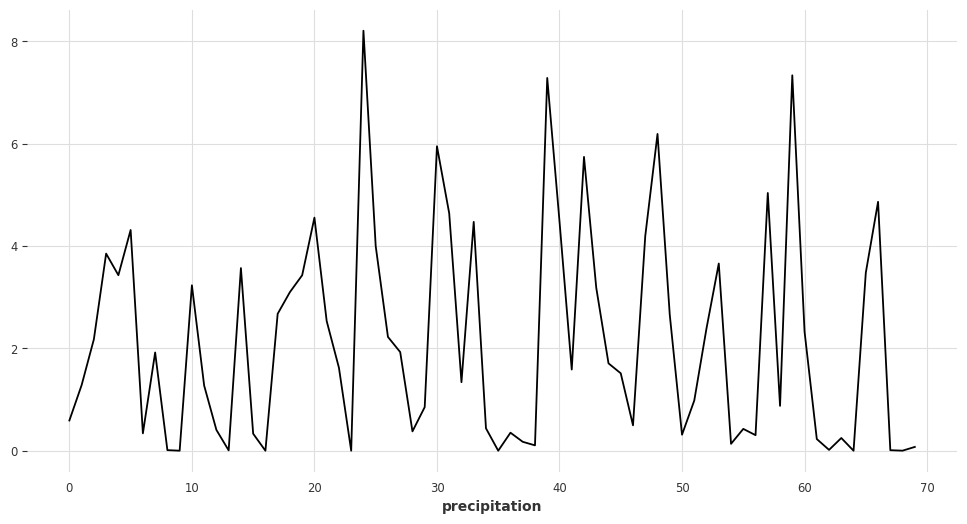

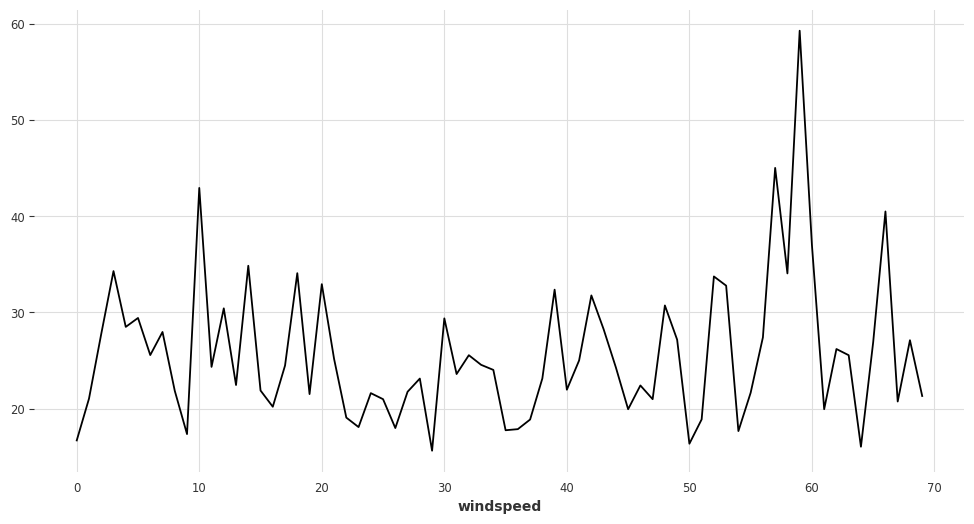

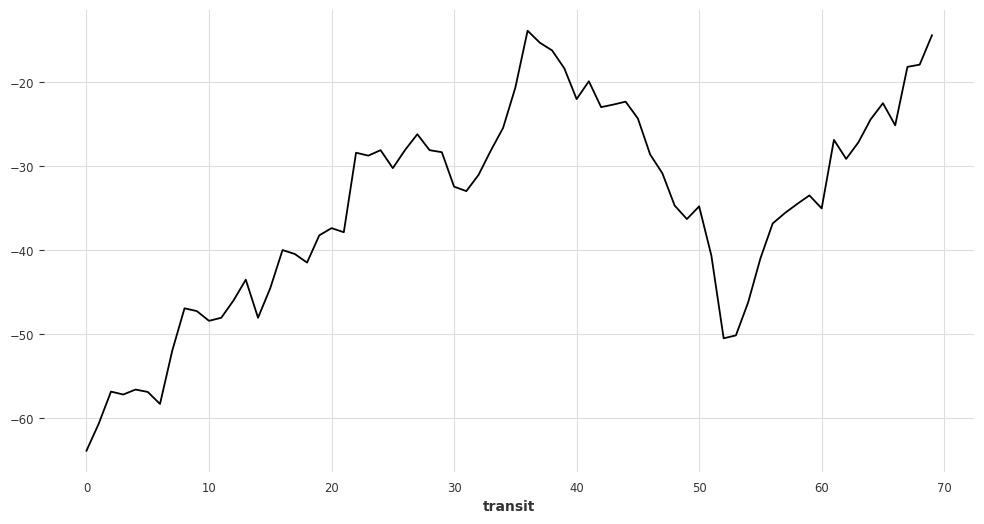

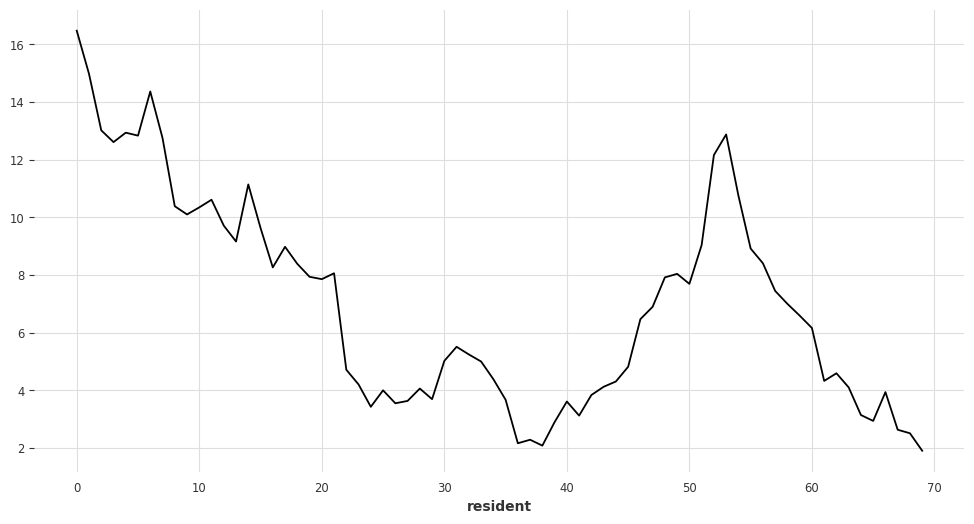

In [106]:
colnames=test.columns[1:12]
colnames
for i in range(len(colnames)):
    plt.figure(100, figsize=(12,6))
    test[colnames[i]].plot()
    plt.xlabel(colnames[i])
    plt.show()
    

In [65]:
test

,week,newcases,newdeaths,icu,hospital,stringency,temperature,humidity,precipitation,windspeed,transit,resident
0,2020-12-28,7522.666667,60.000000,701.666667,1989.333333,78.700000,2.933333,92.500000,0.591000,16.700000,-63.857000,16.476000
1,2021-01-04,7232.857143,107.000000,711.571429,2018.857143,78.700000,2.342857,89.028571,1.282286,21.042857,-60.632714,14.979571
2,2021-01-11,5592.285714,92.142857,689.571429,1813.142857,78.700000,3.428571,83.414286,2.178429,27.771429,-56.816429,13.020286
3,2021-01-18,5105.571429,76.285714,679.428571,1695.857143,79.760000,5.514286,83.857143,3.853000,34.300000,-57.163286,12.611857
4,2021-01-25,4116.142857,65.428571,654.142857,1630.428571,82.410000,3.228571,87.028571,3.431429,28.500000,-56.571429,12.938714
...,...,...,...,...,...,...,...,...,...,...,...,...
65,2022-03-28,22360.142857,16.428571,124.571429,1779.142857,17.490000,4.942857,77.714286,3.480571,26.914286,-22.469429,2.938857
66,2022-04-04,11241.857143,12.142857,102.142857,1500.857143,18.835714,7.757143,79.057143,4.866000,40.500000,-25.102286,3.938714
67,2022-04-11,4722.142857,9.000000,93.428571,1224.464286,19.370000,11.414286,66.614286,0.010143,20.742857,-18.142857,2.632714
68,2022-04-18,2484.285714,8.571429,82.428571,1013.035714,16.198571,12.642857,59.528571,0.001286,27.114286,-17.877714,2.510143


In [14]:
test.describe()

,newcases,newdeaths,icu,hospital,stringency,temperature,humidity,precipitation,windspeed,transit,resident
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,14864.950000,22.695238,374.957823,1155.478231,52.332837,9.717755,80.475782,2.164539,25.742891,-34.827630,7.006012
std,21367.432117,23.102832,238.609166,591.924892,19.866321,5.275337,7.619345,2.128374,7.652888,12.562647,3.686950
min,616.714286,1.428571,70.666667,114.857143,15.670000,-3.785714,57.200000,0.000000,15.628571,-63.857000,1.904667
25%,3012.785714,6.892857,165.892857,490.785714,37.989286,5.492857,76.189286,0.318179,20.985714,-44.239893,3.954036
50%,6531.142857,13.142857,281.142857,1329.357143,49.002143,8.533333,80.921429,1.604643,24.314286,-33.193857,6.530643
75%,14812.642857,32.214286,588.857143,1641.142857,69.242500,13.478571,84.503571,3.547750,29.164286,-25.596893,9.515214
max,117130.000000,107.000000,827.285714,2162.857143,82.410000,19.628571,94.314286,8.210429,59.285714,-13.837000,16.476000


In [64]:
# analyze its seasonality
#for i in range(len(colnames)):
is_seasonal, periodicity=check_seasonality(test.newcases,max_lag=240)
    
dict_seasonal={
    'is seasonal?':is_seasonal,
    'periodicity (week)':f'{periodicity:.1f}', 
    'periodicity (year)': f'{periodicity/52:.1f}'
}
for k, v in dict_seasonal.item():
    print(k,":",v)
# need to re write

AttributeError: 'Series' object has no attribute '_assert_univariate'

In [104]:
# normalize the data
scaler=StandardScaler()
test.scale=pd.DataFrame(scaler.fit_transform(test.iloc[:,1:12].values))
week=test.week.to_frame()
test.std=week.merge(test.scale, left_index=True, right_index=True)
test.std.columns=test.columns

In [105]:
test.std

,week,newcases,newdeaths,icu,hospital,stringency,temperature,humidity,precipitation,windspeed,transit,resident
0,2020-12-28,-0.346101,1.626386,1.379108,1.418889,1.336812,-1.295350,1.589511,-0.744653,-1.190163,-2.327453,2.587061
1,2021-01-04,-0.359762,3.675457,1.420918,1.469127,1.336812,-1.408089,1.130615,-0.417513,-0.618586,-2.068943,2.178259
2,2021-01-11,-0.437096,3.027726,1.328051,1.119083,1.336812,-1.200794,0.388448,0.006573,0.266982,-1.762970,1.643011
3,2021-01-18,-0.460039,2.336398,1.285236,0.919510,1.390554,-0.802569,0.446991,0.799038,1.126228,-1.790779,1.531434
4,2021-01-25,-0.506678,1.863056,1.178500,0.808176,1.524909,-1.238980,0.866230,0.599536,0.362872,-1.743327,1.620727
...,...,...,...,...,...,...,...,...,...,...,...,...
65,2022-03-28,0.353309,-0.273210,-1.056935,1.061229,-1.766528,-0.911671,-0.365049,0.622792,0.154171,0.990829,-1.111087
66,2022-04-04,-0.170786,-0.460055,-1.151610,0.587697,-1.698300,-0.374340,-0.187534,1.278425,1.942229,0.779737,-0.837940
67,2022-04-11,-0.478113,-0.597075,-1.188395,0.117387,-1.671212,0.323919,-1.832386,-1.019535,-0.658070,1.337715,-1.194720
68,2022-04-18,-0.583601,-0.615759,-1.234829,-0.242380,-1.832003,0.558490,-2.769064,-1.023727,0.180493,1.358973,-1.228205


In [132]:
# split the train and test data
def split_data(data):
    train, valid=data[:-5], data[-4:]
 #   train=array(train)
 #   valid=array(valid)
    return train, valid
#train=test.std.iloc[:-5]
#valid=test.std.iloc[-4:]
train, valid=split_data(test.std)

In [133]:
train.shape

(65, 12)